In [15]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [16]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU available, switching to CPU.")

# Generative Adversarial Networks (GANs)

In [17]:
# !mkdir celeba_gan
# !gdown --id 1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684 -O celeba_gan/data.zip
# !unzip -qq celeba_gan/data.zip -d celeba_gan

In [18]:
dataset = keras.utils.image_dataset_from_directory(
    "./celeba_gan/img_align_celeba/",
    label_mode = None,
    image_size = (64,64),
    batch_size = 128,
    smart_resize = True
)

Found 202599 files belonging to 1 classes.


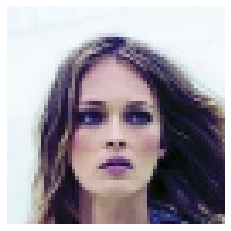

In [19]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x[0,:,:,:].numpy()).astype("uint8"))
    break

# Discriminator

In [20]:
discriminator = keras.Sequential([
    keras.Input(shape=(64,64,3)),
    layers.Conv2D(64,kernel_size=4,strides=2,padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(128,kernel_size=4,strides=2,padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(128,kernel_size=4,strides=2,padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(1,activation="sigmoid")
],
name = "discriminator")

In [21]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 flatten_2 (Flatten)         (None, 8192)            

# Generator

In [22]:
latent_dim = 128

generator = keras.Sequential([
    keras.Input(shape=(latent_dim,)),
    layers.Dense(128*8*8),
    layers.Reshape((8,8,128)),
    layers.Conv2DTranspose(128,kernel_size=4,strides=2,padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(256,kernel_size=4,strides=2,padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(512,kernel_size=4,strides=2,padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(3,kernel_size=5, padding="same", activation="sigmoid")
],
name = "generator")

In [23]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 32, 32, 256)       0 

# GAN network

In [24]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metrics = keras.metrics.Mean(name="d_loss")
        self.g_loss_metrics = keras.metrics.Mean(name="g_loss")
    
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN,self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metrics, self.g_loss_metrics]
        
    
    def train_step(self,real_images):
        
        batch_size = tf.shape(real_images)[0]
        
        # izberemo latent space vektor (+ noise)
        random_latent_vector = tf.random.normal(shape=(batch_size,self.latent_dim))
        # generiramo slike z uporabo generatorja
        generated_imgs = self.generator(random_latent_vector)
        # zmešamo generirane slike skupaj z resničnimi (50/50)
        combined_images = tf.concat([real_images,generated_imgs],axis=0)
        combined_labels = tf.concat([tf.zeros((batch_size,1)), tf.ones((batch_size,1))],axis=0)
        # treniramo diskriminator
        with tf.GradientTape as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(combined_labels, predictions)
        grads = tape.gradient(d_loss,self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
        
        
        
        
        # izberemo latent space vektor + noise
        random_latent_vector = tf.random.normal(shape=(batch_size,self.latent_dim))
        
        # generiramo slike z uporabo generatorja
        # generated_imgs = self.generator(random_latent_vector)
        
        # izluščimo katere slike so resnične in katere ne gelde na diskriminator (extract labels)
        mislabeled_labels = tf.zeros((batch_size,1))
        
        # treniramo generator
        with tf.GradientTape as tape:
            predictions = self.discriminator(self.generator(random_latent_vector))
            g_loss = self.loss_fn(mislabeled_labels, predictions)
        grads = tape.gradient(d_loss,self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.d_loss_metrics.update_state(d_loss)
        self.g_loss_metrics.update_state(g_loss)
        
        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}
        

In [25]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f"generated_img_{epoch:03d}_{i}.png")

In [26]:
epochs = 3

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset,
    epochs=epochs,
    callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/3


AttributeError: in user code:

    File "c:\Users\Fakulteta\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Fakulteta\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Fakulteta\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "<ipython-input-24-41af694799d3>", line 33, in train_step
        with tf.GradientTape as tape:

    AttributeError: __enter__
